# Source: [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

# Install Package

In [ ]:
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git
!pip install gtts
from gtts import gTTS
!pip install IPython
from IPython.display import Audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 58.5 MB/s 
     |████████████████████████████████| 6.6 MB 39.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tynog9mt
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-tynog9mt
     |████████████████████████████████| 53 kB 1.3 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=a76989f19dead6c2974293116a79ce64fbba71017c97a667f39f02dde833acb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-h3

In [ ]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

# Import Modules

In [ ]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')


#Model

In [ ]:
class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

# Caption Prediction

In [ ]:
def generate(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list

# Choose Pretrained Model
Choose whether Action or Image Captioning.

In [ ]:
pretrained_model = 'Action'  # @param ['Action', 'Image']

if pretrained_model == 'Action':
  downloader.download_file("1mqAylPNTxtsRVI0X72Dxy_kgCi24BlwP", model_path)
else:
  downloader.download_file("1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX", model_path)

# Using CLIP Model + GPT2 tokenizer (Better Language Pretrained Model)

In [ ]:
is_gpu = False
device = CUDA(0) if is_gpu else "cpu" #CUDA = GPU
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 128MiB/s]


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

# Load model weights (pretrained model; Action or Image)

In [ ]:
prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

# Upload Image

In [ ]:
uploaded = files.upload()

if not uploaded:
  UPLOADED_FILE = ''
elif len(uploaded) == 1:
  UPLOADED_FILE = list(uploaded.keys())[0]
else:
  raise AssertionError('Please upload one image at a time')

print(UPLOADED_FILE)

Saving 793558.jpg to 793558.jpg
793558.jpg


# Result (Predict Caption)

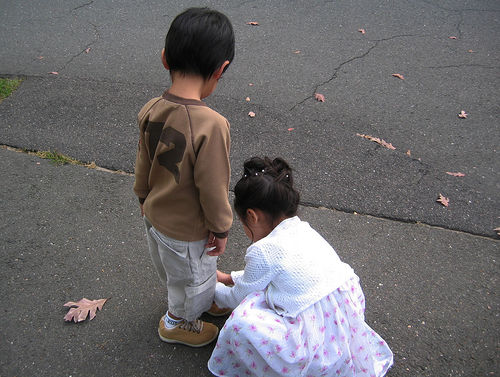

100%|██████████| 1/1 [00:21<00:00, 21.79s/it]



 A young boy and girl are kneeling on the sidewalk.


In [ ]:
image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
generated_text_prefix = generate(model, tokenizer, embed=prefix_embed)
#print('\n')
#print(generated_text_prefix)

alpha = generated_text_prefix
beta = []
for s in alpha:
    s = s.split('.')
    # Explanation 1
    s = list(filter(lambda s: s!= '',s))
    # Explanation 2
    beta = beta + s
res = beta[0]+'.'
print('\n')
print(res)
Org = gTTS(text=res,lang='en')
Org.save('original.mp3')
Audio("original.mp3")

# Translation

In [ ]:
!pip install googletrans
from googletrans import Translator
translator = Translator()

!pip install -q pythainlp[translate] sentencepiece sklearn-pycrfsuite
exit()
from pythainlp.translate import Translate
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 9.5 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=24c4c6d4fc46dd2dd9cbfb62ccb18fb5529998a14f0c21b2cff67aaec373815e
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans
     |████████████████████████████████| 11.5 MB 4.7 MB/s 
     |████████████████████████████████| 1.2 MB 31.5 MB/s 
     |████████████████████████████████| 485 kB 38.5 MB/s 
     |████████████████████████████████| 880 kB 43.9 MB/s 
     |████████████████████████████████| 10.9 MB 27.9 MB/s 
     |█████████████████████████

In [ ]:
Translation = "PyThaiNLP" #@param ["PyThaiNLP", "Google Translate"]
if Translation == 'Google Translate':
    Answer = translator.translate(res, src='en', dest= 'th').text
    Ans = gTTS(text=Answer,lang='th')
    Ans.save('google.mp3')
    print(Answer)
    Audio("google.mp3") 
else: 
    en2th = Translate('en', 'th')
    input = res
    trans = en2th.translate(input)
    Res = gTTS(text=trans,lang='th')
    Res.save('result.mp3')
    print(trans)
    Audio("result.mp3")

2022-06-19 07:21:32 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


Corpus: scb_1m_en-th_moses
- Downloading: scb_1m_en-th_moses 1.0


100%|██████████| 1174648148/1174648148 [00:49<00:00, 23495772.84it/s]
2022-06-19 07:22:43 | INFO | fairseq.file_utils | loading archive file /root/pythainlp-data/scb_1m_en-th_moses/SCB_1M-MT_OPUS+TBASE_en-th_moses-spm_130000-16000_v1.0/models
2022-06-19 07:22:43 | INFO | fairseq.file_utils | loading archive file /root/pythainlp-data/scb_1m_en-th_moses/SCB_1M-MT_OPUS+TBASE_en-th_moses-spm_130000-16000_v1.0/vocab
2022-06-19 07:22:49 | INFO | fairseq.tasks.translation | [en] dictionary: 130000 types
2022-06-19 07:22:49 | INFO | fairseq.tasks.translation | [th] dictionary: 15984 types
2022-06-19 07:22:51 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': './checkpoints/1m-scb+mt-opus_27.5.2020/en-th/moses-spm/130000-16000/log', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 

เด็กชายและเด็กหญิงกําลังคุกเข่าอยู่บนทางเท้า
